In [1]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

# Veri dizinleri
train_dir = "/kaggle/input/classed-odir5k-splited-into-train-test/train"
test_dir = "/kaggle/input/classed-odir5k-splited-into-train-test/test"
img_size = (224, 224)
batch_size = 64
epochs = 100  # İlk eğitim için epoch sayısı

# Veri setlerini yükle
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical',  # Etiketleri one-hot encode et
    shuffle=True,
    seed=42
)

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical',  # Etiketleri one-hot encode et
    shuffle=False
)

from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomContrast

# Veri artırma (Data Augmentation) katmanları
data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal_and_vertical"),
    RandomRotation(0.2),
    RandomZoom(0.2),
    RandomContrast(0.2)
])



# Veri setine artırma uygula
train_dataset = train_dataset.map(
    lambda x, y: (data_augmentation(x, training=True), y)
)

# Normalizasyon katmanı
preprocess_input = tf.keras.applications.vgg16.preprocess_input

# Veri setine normalizasyon uygula
train_dataset = train_dataset.map(
    lambda x, y: (preprocess_input(x), y)
)
test_dataset = test_dataset.map(
    lambda x, y: (preprocess_input(x), y)
)

# Veri setlerini performans için optimize et
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)


Found 17555 files belonging to 8 classes.
Found 4392 files belonging to 8 classes.


In [2]:
from tensorflow.keras.applications import ResNet50, VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# ResNet50 ve VGG16 modellerini yükle (transfer öğrenme)
resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Her iki modelin katmanlarını dondur
resnet_model.trainable = False
vgg_model.trainable = False

# Input layer
inputs = Input(shape=(224, 224, 3))

# ResNet50 ve VGG16 modellerini ayrı ayrı uygula
resnet_output = resnet_model(inputs)
vgg_output = vgg_model(inputs)

# ResNet50 ve VGG16 çıktılarını GlobalAveragePooling2D ile düzleştir
resnet_output = GlobalAveragePooling2D()(resnet_output)
vgg_output = GlobalAveragePooling2D()(vgg_output)

# İki modelin çıktılarını birleştir
combined = Concatenate()([resnet_output, vgg_output])

# Fully Connected Layer
x = Dense(512, activation='relu')(combined)
x = Dropout(0.5)(x)

# Output Layer
outputs = Dense(train_dataset.element_spec[1].shape[1], activation='softmax')(x)  # Sınıf sayısı

# Hibrit modeli oluştur
model = Model(inputs, outputs)

# Modeli derle
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('hybrid_resnet50_vgg16.keras', save_best_only=True, monitor='val_accuracy')

# İlk eğitim (transfer öğrenme)
history = model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=test_dataset,
    callbacks=[early_stopping, model_checkpoint]
)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/100
275/275 ━━━━━━━━━━━━━━━━━━━━ 305s 1s/step - accuracy: 0.7288 - loss: 1.1467 - val_accuracy: 0.8597 - val_loss: 0.3799
Epoch 2/100
275/275 ━━━━━━━━━━━━━━━━━━━━ 251s 911ms/step - accuracy: 0.8400 - loss: 0.4558 - val_accuracy: 0.8657 - val_loss: 0.3647
Epoch 3/100
275/275 ━━━━━━━━━━━━━━━━━━━━ 250s 909ms/step - accuracy: 0.8496 - loss: 0.4159 - val_accuracy: 0.8700 - val_loss: 0.3614
Epoch 4/100
275/275 ━━━━━━━━━━━━━━━━━━━━ 249s 904ms/step - accuracy: 0.8470 - loss: 0.4072 - val_accuracy: 0.8759 - val_loss: 0.3503
Epoch 5/100
275/275 ━━━━━━━━━━━━━━━━━━━━ 247s 898ms/step - accuracy: 0.8499 - loss: 0.4017 - val_accuracy: 0.8743 - val_loss: 0.3442
Epoch 6/100
275/275 ━━━━━━━━━━━━━━━━━━━━ 248s 901ms/step - accuracy: 0.8583 - loss: 0.3851 - val_accuracy: 0.8689 - val_loss: 0.3532
Epoch 7/100
275/275 ━━━━━━━━━━━━━━━━━━━━ 245s 891ms/step - accuracy: 0.8514 - loss: 0.3909 - val_accura

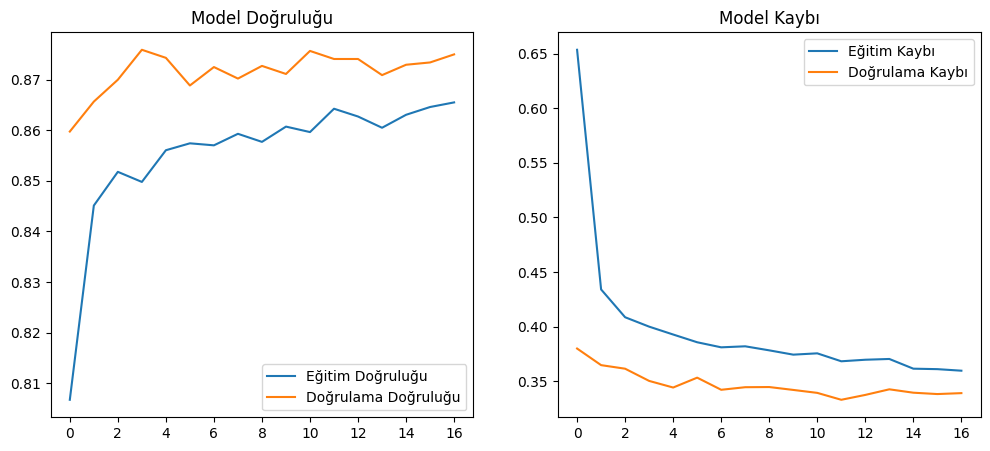

In [3]:
# Sonuçları görselleştir
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu')
plt.plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu')
plt.title('Model Doğruluğu')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Eğitim Kaybı')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
plt.title('Model Kaybı')
plt.legend()

plt.show()

In [4]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Test veri kümesini tahmin et
true_labels = []
predicted_labels = []

for images, labels in test_dataset:
    preds = model.predict(images)
    predicted_classes = np.argmax(preds, axis=1)
    true_classes = np.argmax(labels.numpy(), axis=1)

    predicted_labels.extend(predicted_classes)
    true_labels.extend(true_classes)

# Performans raporu
unique_classes = sorted(set(true_labels + predicted_labels))
target_names = [str(cls) for cls in unique_classes]
report = classification_report(true_labels, predicted_labels, target_names=target_names)
print("Classification Report:\n", report)

# Confusion matrix
cmp = confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix:\n", cmp)


2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 59ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
2/2 ━━━━━━━

Attention

In [7]:
from tensorflow.keras.applications import ResNet50, VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input, Concatenate, Multiply, Reshape, Activation, Conv2D, Add, Layer
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf

# Channel Attention Layer
class ChannelAttention(Layer):
    def __init__(self, ratio=8, **kwargs):
        super(ChannelAttention, self).__init__(**kwargs)
        self.ratio = ratio
        self.global_avg_pool = GlobalAveragePooling2D()
        self.global_max_pool = tf.reduce_max
        self.dense1 = Dense(units=1, activation='relu', kernel_initializer='he_normal', use_bias=False)
        self.dense2 = Dense(units=1, kernel_initializer='he_normal', use_bias=False)
        self.reshape = Reshape((1, 1, -1))
        self.add = Add()
        self.activation = Activation('sigmoid')
        self.multiply = Multiply()

    def call(self, inputs):
        channel = inputs.shape[-1]
        
        # Global Average Pooling
        avg_pool = self.global_avg_pool(inputs)
        avg_pool = self.reshape(avg_pool)
        
        # Global Max Pooling
        max_pool = tf.reduce_max(inputs, axis=[1, 2], keepdims=True)
        
        # Shared MLP
        avg_pool = self.dense1(avg_pool)
        max_pool = self.dense1(max_pool)
        
        avg_pool = self.dense2(avg_pool)
        max_pool = self.dense2(max_pool)
        
        # Add and Sigmoid
        channel_attention = self.add([avg_pool, max_pool])
        channel_attention = self.activation(channel_attention)
        
        return self.multiply([inputs, channel_attention])

# Spatial Attention Layer
class SpatialAttention(Layer):
    def __init__(self, kernel_size=7, **kwargs):
        super(SpatialAttention, self).__init__(**kwargs)
        self.kernel_size = kernel_size
        self.concat = Concatenate(axis=-1)
        self.conv = Conv2D(filters=1, kernel_size=kernel_size, padding='same', activation='sigmoid', kernel_initializer='he_normal')
        self.multiply = Multiply()

    def call(self, inputs):
        # Average Pooling and Max Pooling along the channel axis
        avg_pool = tf.reduce_mean(inputs, axis=-1, keepdims=True)
        max_pool = tf.reduce_max(inputs, axis=-1, keepdims=True)
        
        # Concatenate along the channel axis
        concat = self.concat([avg_pool, max_pool])
        
        # Convolution layer
        spatial_attention = self.conv(concat)
        
        return self.multiply([inputs, spatial_attention])

# ResNet50 ve VGG16 modellerini yükle (transfer öğrenme)
resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Her iki modelin katmanlarını dondur
resnet_model.trainable = False
vgg_model.trainable = False

# Input layer
inputs = Input(shape=(224, 224, 3))

# ResNet50 ve VGG16 modellerini ayrı ayrı uygula
resnet_output = resnet_model(inputs)
vgg_output = vgg_model(inputs)

# Channel Attention ekle
resnet_output = ChannelAttention(ratio=8)(resnet_output)
vgg_output = ChannelAttention(ratio=8)(vgg_output)

# Spatial Attention ekle
resnet_output = SpatialAttention(kernel_size=7)(resnet_output)
vgg_output = SpatialAttention(kernel_size=7)(vgg_output)

# ResNet50 ve VGG16 çıktılarını GlobalAveragePooling2D ile düzleştir
resnet_output = GlobalAveragePooling2D()(resnet_output)
vgg_output = GlobalAveragePooling2D()(vgg_output)

# İki modelin çıktılarını birleştir
combined = Concatenate()([resnet_output, vgg_output])

# Fully Connected Layer
x = Dense(512, activation='relu')(combined)
x = Dropout(0.5)(x)

# Output Layer
outputs = Dense(train_dataset.element_spec[1].shape[1], activation='softmax')(x)  # Sınıf sayısı

# Hibrit modeli oluştur
model = Model(inputs, outputs)

# Modeli derle
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('hybrid_resnet50_vgg16_with_attention.keras', save_best_only=True, monitor='val_accuracy')

# İlk eğitim (transfer öğrenme)
history = model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=test_dataset,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/100
275/275 ━━━━━━━━━━━━━━━━━━━━ 267s 923ms/step - accuracy: 0.7538 - loss: 0.7475 - val_accuracy: 0.8643 - val_loss: 0.3808
Epoch 2/100
275/275 ━━━━━━━━━━━━━━━━━━━━ 245s 891ms/step - accuracy: 0.8466 - loss: 0.4245 - val_accuracy: 0.8682 - val_loss: 0.3680
Epoch 3/100
275/275 ━━━━━━━━━━━━━━━━━━━━ 249s 903ms/step - accuracy: 0.8522 - loss: 0.4017 - val_accuracy: 0.8704 - val_loss: 0.3508
Epoch 4/100
275/275 ━━━━━━━━━━━━━━━━━━━━ 246s 892ms/step - accuracy: 0.8580 - loss: 0.3794 - val_accuracy: 0.8670 - val_loss: 0.3509
Epoch 5/100
275/275 ━━━━━━━━━━━━━━━━━━━━ 247s 895ms/step - accuracy: 0.8618 - loss: 0.3715 - val_accuracy: 0.8704 - val_loss: 0.3436
Epoch 6/100
275/275 ━━━━━━━━━━━━━━━━━━━━ 246s 894ms/step - accuracy: 0.8639 - loss: 0.3660 - val_accuracy: 0.8684 - val_loss: 0.3415
Epoch 7/100
275/275 ━━━━━━━━━━━━━━━━━━━━ 244s 887ms/step - accuracy: 0.8672 - loss: 0.3559 - val_accuracy: 0.8716 - val_loss: 0.3472
Epoch 8/100
275/275 ━━━━━━━━━━━━━━━━━━━━ 249s 903ms/step - accuracy: 

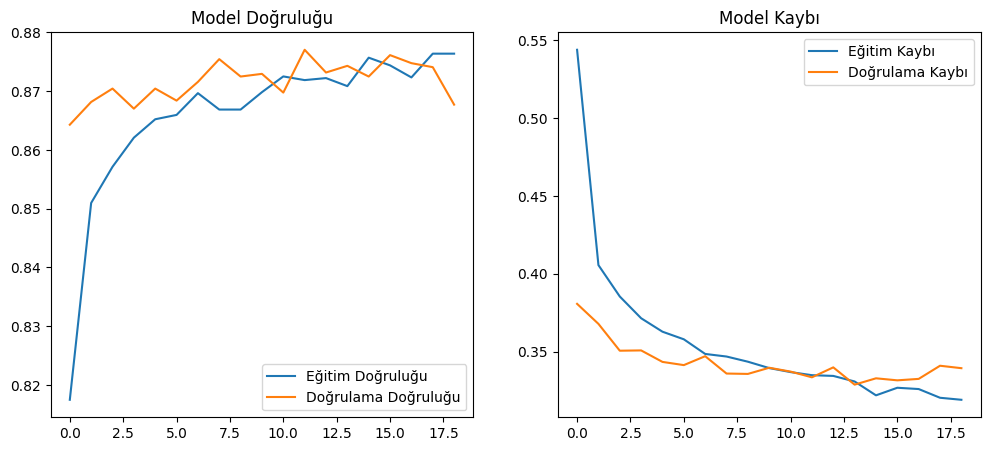

In [8]:
# Sonuçları görselleştir
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu')
plt.plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu')
plt.title('Model Doğruluğu')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Eğitim Kaybı')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
plt.title('Model Kaybı')
plt.legend()

plt.show()

In [9]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Test veri kümesini tahmin et
true_labels = []
predicted_labels = []

for images, labels in test_dataset:
    preds = model.predict(images)
    predicted_classes = np.argmax(preds, axis=1)
    true_classes = np.argmax(labels.numpy(), axis=1)

    predicted_labels.extend(predicted_classes)
    true_labels.extend(true_classes)

# Performans raporu
unique_classes = sorted(set(true_labels + predicted_labels))
target_names = [str(cls) for cls in unique_classes]
report = classification_report(true_labels, predicted_labels, target_names=target_names)
print("Classification Report:\n", report)

# Confusion matrix
cmp = confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix:\n", cmp)


2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
2/2 ━━━━━━━━